In [1]:
from catboost import CatBoostClassifier
from matplotlib.pyplot import plot
from numpy import nan
from numpy import ndarray
from numpy import unique
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
train_fname = '../input/spaceship-titanic/train.csv'
train_df = read_csv(filepath_or_buffer=train_fname)

In [3]:
# todo try using dummies here instead of a label encoder
def prepare(input_df: DataFrame) -> ndarray:
    result_df = input_df.drop(columns=['Transported', ], errors='ignore').copy(deep=True)
    result_df['Cabin_Deck'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[0])
    result_df['Cabin_Side'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[2])
    columns = ['CryoSleep', 'Destination', 'HomePlanet', 'Cabin_Deck', 'Cabin_Side', 'VIP']
    for column in columns:
        result_df[column] = LabelEncoder().fit_transform(y=result_df[column])
    result_df = result_df.drop(columns=['Cabin', 'Name', 'PassengerId',])
    return result_df

# get the labels
y = train_df['Transported'].values
x_df = prepare(input_df=train_df)
imputer = KNNImputer(missing_values=nan, n_neighbors=3, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,)
x = imputer.fit_transform(x_df)

In [4]:
# split
random_state = 1
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)

In [5]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate = 0.01,
    random_seed=random_state,
)

In [6]:
model.fit(X=x, y=y, eval_set=(x_test, y_test)) 

0:	learn: 0.6876962	test: 0.6879083	best: 0.6879083 (0)	total: 61.2ms	remaining: 2m 2s
1:	learn: 0.6827502	test: 0.6830896	best: 0.6830896 (1)	total: 64.5ms	remaining: 1m 4s
2:	learn: 0.6776248	test: 0.6781944	best: 0.6781944 (2)	total: 67.8ms	remaining: 45.1s
3:	learn: 0.6730299	test: 0.6735735	best: 0.6735735 (3)	total: 70.8ms	remaining: 35.3s
4:	learn: 0.6689512	test: 0.6696056	best: 0.6696056 (4)	total: 73.9ms	remaining: 29.5s
5:	learn: 0.6640969	test: 0.6648750	best: 0.6648750 (5)	total: 76.9ms	remaining: 25.6s
6:	learn: 0.6593919	test: 0.6603133	best: 0.6603133 (6)	total: 80ms	remaining: 22.8s
7:	learn: 0.6551666	test: 0.6561779	best: 0.6561779 (7)	total: 83ms	remaining: 20.7s
8:	learn: 0.6508466	test: 0.6518872	best: 0.6518872 (8)	total: 86ms	remaining: 19s
9:	learn: 0.6468992	test: 0.6479726	best: 0.6479726 (9)	total: 89.2ms	remaining: 17.7s
10:	learn: 0.6428375	test: 0.6440090	best: 0.6440090 (10)	total: 92.2ms	remaining: 16.7s
11:	learn: 0.6389430	test: 0.6402458	best: 0.6402

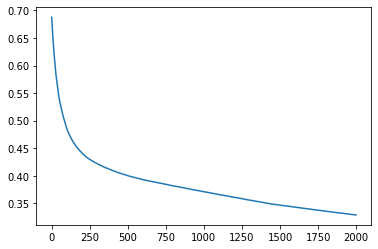

In [7]:
plot(model.evals_result_['learn']['Logloss'])

<AxesSubplot:>

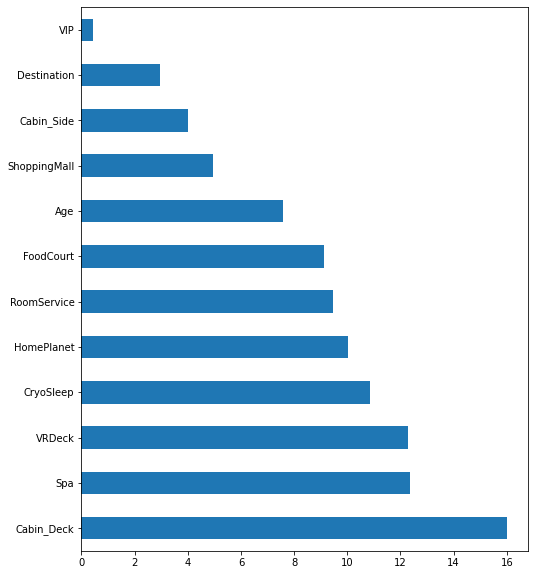

In [8]:
importance = Series(model.feature_importances_, index=x_df.columns)
importance.nlargest(30).plot(kind='barh', figsize=(8,10))

In [9]:
submission_df = read_csv('../input/spaceship-titanic/test.csv')
ids = submission_df['PassengerId'].values
submission_data_df = prepare(input_df=submission_df)
submission_data = imputer.transform(submission_data_df)
output_df = DataFrame({'PassengerId': ids, 'Transported': model.predict(submission_data) })
output_df.to_csv('submission.csv', index=False)

{'False': 1980, 'True': 2297}

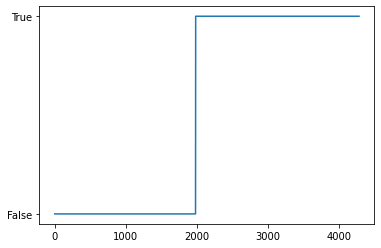

In [10]:
y_pred = model.predict(submission_data)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))